# Stacking SEDs

/var/folders/st/ng23bqyd59ndbk5_qmpyq8rr0000gn/T/ipykernel_50212/1924731576.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not hasattr(np, "float"):


Imports complete
Loaded 7 MGF targets from /Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GBM_eMGF_candidates.txt
FERMI LAT — per-event SED profiles → stacked SED

Analyzing GRB_231115A
[gtselect] time -p gtselect infile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_231115A/L250924144851039FD35858_EV00.fits outfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_231115A/filtered.fits ra=148.968458 dec=69.679703 rad=12.0 tmin=721755386.0 tmax=721756386.0 emin=100.0 emax=10000.0 zmin=0.0 zmax=100.0 evclass=8 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
time -p gtselect infile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/GRB_231115A/L250924144851039FD35858_EV00.fits outfile=/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis/GRB_231115A/filtered.fits ra=148.968458 dec=69.679703 rad=12.0 tmin=721755386.0 tmax=721756386.0 emin=100.0 emax

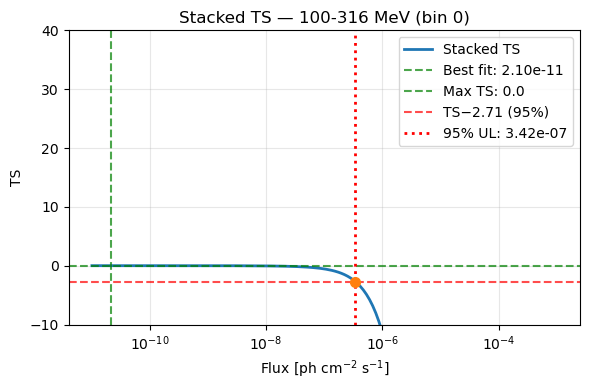

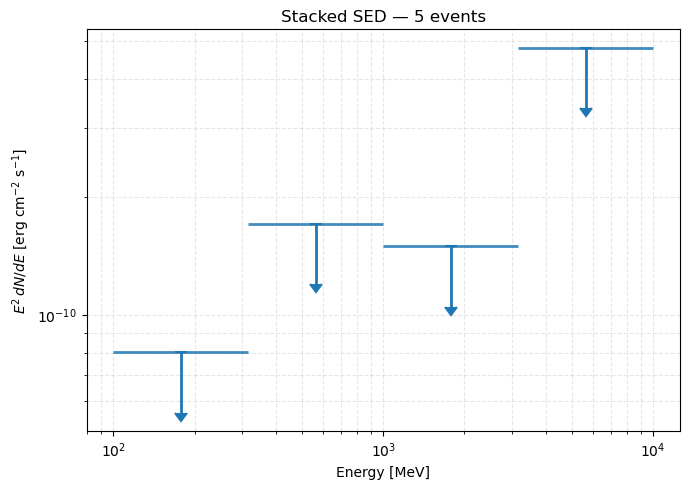

In [2]:
# =====================================================================
# Fermi-LAT: Per-event SED profile scans  →  stacked SED (profile-likelihood)
# =====================================================================
import os
import numpy as np
import pandas as pd
from pathlib import Path
from astropy.io import fits
from astropy.time import Time
import matplotlib.pyplot as plt
from shutil import rmtree

# Fermitools
import gt_apps as my_apps
from UnbinnedAnalysis import UnbinnedObs, UnbinnedAnalysis
from LATSourceModel import SourceList
from LikelihoodState import LikelihoodState

# ---------- numpy compat ----------
if not hasattr(np, "float"):
    np.float = float

print("Imports complete")

# =====================================================================
# TARGETS
# =====================================================================
FERMI_EPOCH = Time('2001-01-01T00:00:00', scale='utc')

def utc_to_met(t0, time_kind="auto"):
    if time_kind == "met":
        return float(t0)
    if time_kind == "utc":
        t = t0 if isinstance(t0, Time) else Time(str(t0), scale='utc', format='iso')
        return (t - FERMI_EPOCH).to_value('sec')
    if isinstance(t0, (int, float)):
        return float(t0)
    if isinstance(t0, Time):
        return (t0 - FERMI_EPOCH).to_value('sec')
    return (Time(str(t0), scale='utc', format='iso') - FERMI_EPOCH).to_value('sec')

def build_target(name, ra_deg, dec_deg, t0, dt_s, time_kind="auto"):
    t0_met = float(utc_to_met(t0, time_kind=time_kind))
    dt_s = float(dt_s)
    return dict(
        name=str(name),
        ra=float(ra_deg),
        dec=float(dec_deg),
        t0_utc=(str(t0) if time_kind != "met" else None),
        t0_met=t0_met,
        dt=dt_s,
        tmin=t0_met,
        tmax=t0_met + dt_s,
    )

# Read your catalog of candidates
BASE = Path("/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger")
MGF_LIST = BASE / "GBM_eMGF_candidates.txt"
df = pd.read_csv(MGF_LIST, sep=r"\s+", comment="#")

# Window (s) for each target
del_T = 1000.0

targets = [
    build_target(
        row.GRB_name,
        float(row.gal_ra_deg),
        float(row.gal_dec_deg),
        float(row.MET_trig_time),
        del_T,
        time_kind="met",
    )
    for _, row in df.iterrows()
]
print(f"Loaded {len(targets)} MGF targets from {MGF_LIST}")

# =====================================================================
# CONFIG
# =====================================================================
DATA_DIR = BASE                    # GRB_* subfolders live here
WORK_DIR = BASE / "MGF_Stacking_Analysis"
WORK_DIR.mkdir(parents=True, exist_ok=True)

OVERWRITE_RUN = True

EMIN = 100.0
EMAX = 10000.0
ROI  = 12.0
ZMIN = 0.0
ZMAX = 100.0
EVCLASS = 8
EVTYPE  = 3
IRFS    = "P8R3_TRANSIENT020E_V3"
INDEX   = 2.0  # PowerLaw2 fixed photon index

CATALOG  = str(BASE / "gll_psc_v35.fit")
GAL_DIFF = str(BASE / "gll_iem_v07_cut.fits")
ISO_DIFF = os.path.join(
    os.environ.get("FERMI_DIR", ""),
    "refdata/fermi/galdiffuse/iso_P8R3_TRANSIENT020E_V3_v1.txt"
)

# SED binning (common to all events) and flux grid for profile scans
EDGES = np.array([100, 316, 1000, 3162, 10000], float)
# SED binning (2 bins per decade, extended with two bins above 10 GeV)
GAMMA_FIXED_MAG = 2.0

FLUX_GRID = np.concatenate(([0.0], np.logspace(-11, -3, 150)))
DELTA_CHI2_95 = 2.71  # one-sided 95% ~ ΔTS = 2.71

# =====================================================================
# I/O HELPERS
# =====================================================================
def find_ft1_ft2(data_dir: Path):
    ft1_patterns = [
        "L*_EV00.fits", "*_EV00.fits", "*_EV*.fits",
        "L*_PH00.fits", "*_PH00.fits", "*_PH*.fits",
        "gll_ft1_tr_*.fit", "gll_ft1_*.fit",
    ]
    ft2_patterns = [
        "L*_SC00.fits", "*_SC00.fits", "*_SC*.fits",
        "spacecraft*.fits", "*_SC.fits",
    ]
    def first_match(patterns):
        for pat in patterns:
            files = sorted(data_dir.glob(pat))
            if files:
                return str(files[0])
        return None
    ft1 = first_match(ft1_patterns)
    ft2 = first_match(ft2_patterns)
    if not ft1 or not ft2:
        raise FileNotFoundError(f"Missing FT1/FT2 in {data_dir}. Found FT1={ft1}, FT2={ft2}")
    return ft1, ft2

def _clean_work_dirs():
    if OVERWRITE_RUN and WORK_DIR.exists():
        for d in WORK_DIR.iterdir():
            if d.is_dir():
                try:
                    rmtree(d)
                except Exception:
                    pass

def ensure_nonempty_gti(gti_fits):
    with fits.open(gti_fits) as hdul:
        if "GTI" not in hdul or len(hdul["GTI"].data) == 0:
            raise RuntimeError("Empty GTI")

# =====================================================================
# GTTOOLS WRAPPERS
# =====================================================================
def gtselect_filter_events(ifl, gtselect_outfile, evclass, evtype, ra, dec, rad,
                           tmin, tmax, emin, emax, zmin, zmax):
    my_apps.filter['infile']  = str(ifl)
    my_apps.filter['outfile'] = str(gtselect_outfile)
    my_apps.filter['evclass'] = int(evclass)
    my_apps.filter['evtype']  = int(evtype)
    my_apps.filter['ra']      = float(ra)
    my_apps.filter['dec']     = float(dec)
    my_apps.filter['rad']     = float(rad)
    my_apps.filter['tmin']    = float(tmin)
    my_apps.filter['tmax']    = float(tmax)
    my_apps.filter['emin']    = float(emin)
    my_apps.filter['emax']    = float(emax)
    my_apps.filter['zmin']    = float(zmin)
    my_apps.filter['zmax']    = float(zmax)
    print("[gtselect]", my_apps.filter.command())
    my_apps.filter.run()
    return gtselect_outfile

def gtmaketime_events(scfile, evfile, gtmaketime_ofl, ra_src, dec_src, roi_deg, zmax_deg):
    filt = ("(DATA_QUAL>0)&&(LAT_CONFIG==1)&&(IN_SAA==F)&&(LIVETIME>0)&&"
            f"(ANGSEP(RA_ZENITH,DEC_ZENITH,{ra_src:.6f},{dec_src:.6f})<={zmax_deg - roi_deg:.1f})")
    my_apps.maketime['scfile']   = str(scfile)
    my_apps.maketime['sctable']  = "SC_DATA"
    my_apps.maketime['filter']   = filt
    my_apps.maketime['roicut']   = "no"
    my_apps.maketime['evfile']   = str(evfile)
    my_apps.maketime['evtable']  = "EVENTS"
    my_apps.maketime['outfile']  = str(gtmaketime_ofl)
    print("[gtmktime]", my_apps.maketime.command())
    my_apps.maketime.run()
    return gtmaketime_ofl

def gt_ltcube(scfile, evfile, ltcube_outfile):
    my_apps.expCube['evfile']    = str(evfile)
    my_apps.expCube['scfile']    = str(scfile)
    my_apps.expCube['outfile']   = str(ltcube_outfile)
    my_apps.expCube['zmax']      = 180.0
    my_apps.expCube['dcostheta'] = 0.025
    my_apps.expCube['binsz']     = 1.0
    print("[gtltcube]", my_apps.expCube.command())
    my_apps.expCube.run()
    return ltcube_outfile

def exp_map(expmap_input_ifl, scfile, ltcube_file, expmap_outfile, irf):
    my_apps.expMap['evfile']    = str(expmap_input_ifl)
    my_apps.expMap['scfile']    = str(scfile)
    my_apps.expMap['expcube']   = str(ltcube_file)
    my_apps.expMap['outfile']   = str(expmap_outfile)
    my_apps.expMap['irfs']      = str(irf)
    my_apps.expMap['srcrad']    = 24.0
    my_apps.expMap['nlong']     = 48
    my_apps.expMap['nlat']      = 48
    my_apps.expMap['nenergies'] = 20
    print("[gtexpmap]", my_apps.expMap.command())
    my_apps.expMap.run()
    return expmap_outfile

def diff_rsp(diffrsp_evfile, scfile, srcmdl, irf):
    my_apps.diffResps['evfile']  = str(diffrsp_evfile)
    my_apps.diffResps['scfile']  = str(scfile)
    my_apps.diffResps['srcmdl']  = str(srcmdl)
    my_apps.diffResps['irfs']    = str(irf)
    my_apps.diffResps['evtable'] = "EVENTS"
    my_apps.diffResps['sctable'] = "SC_DATA"
    print("[gtdiffrsp]", my_apps.diffResps.command())
    my_apps.diffResps.run()

def build_model_and_diffresp(work_dir, gti_file, ft2, ra, dec, src_name):
    xml = work_dir / "model.xml"
    sl = SourceList(
        catalog_file=CATALOG,
        ROI=str(gti_file),
        output_name="base.xml",
        write_directory=str(work_dir)
    )
    sl.make_model(
        galactic_file=GAL_DIFF,
        isotropic_file=ISO_DIFF,
        free_radius=1e-6,
        sigma_to_free=1e9,
        norms_free_only=True,
        variable_free=False
    )
    pl2 = {
        "model": "PowerLaw2",
        "Integral": 1e-9,
        "Integral_free": True,
        "Index": INDEX,
        "Index_free": False,
        "LowerLimit": EMIN,
        "LowerLimit_free": False,
        "UpperLimit": EMAX,
        "UpperLimit_free": False
    }
    sl.add_point_source(
        src_name, RA=ra, DEC=dec,
        spectrum_model=pl2,
        new_model_name=str(xml),
        overwrite=True
    )
    diff_rsp(diffrsp_evfile=gti_file, scfile=ft2, srcmdl=xml, irf=IRFS)
    return str(xml)

# =====================================================================
# PROFILE/SED HELPERS
# =====================================================================
def _freeze_all_params(like):
    npars = len(like.model.params)
    for k in range(npars):
        try: like.freeze(k)
        except Exception: pass


def _free_diffuse_norms(like):
    """
    Free ONLY diffuse amplitudes:
      - gll_iem_* : free Spectrum.Prefactor ; keep Spectrum.Index & Spatial.Normalization fixed
      - iso_*     : free Spectrum.Normalization
    Do NOT free any spectral indices or spatial scalings.
    """
    for s in like.sourceNames():
        sl = s.lower()
        if ('gll_iem' in sl) or ('gal' in sl):
            # Galactic diffuse: PowerLaw spectrum + MapCubeFunction spatial
            try:
                spec = like.model[s].funcs['Spectrum']
                # Free the spectral amplitude
                try: spec.getParam('Prefactor').setFree(True)
                except Exception: pass
                # Ensure slope & other knobs stay fixed
                for pname in ('Index', 'Scale', 'Normalization'):
                    try: spec.getParam(pname).setFree(False)
                    except Exception: pass
            except Exception:
                pass
            # Keep spatial Normalization at 1 and fixed
            try:
                spat = like.model[s].funcs.get('Spatial', None)
                if spat is not None:
                    try: spat.getParam('Normalization').setFree(False)
                    except Exception: pass
            except Exception:
                pass

        elif ('iso_' in sl):
            # Isotropic diffuse: FileFunction spectrum + ConstantValue spatial
            try:
                spec = like.model[s].funcs['Spectrum']
                # Free the scalar amplitude
                try: spec.getParam('Normalization').setFree(True)
                except Exception: pass
                # No Index in FileFunction; ensure anything else is fixed
                for pname in ('Prefactor','Value','Scale','Index'):
                    try: spec.getParam(pname).setFree(False)
                    except Exception: pass
            except Exception:
                pass
            # Spatial ConstantValue should remain fixed
            try:
                spat = like.model[s].funcs.get('Spatial', None)
                if spat is not None:
                    try: spat.getParam('Value').setFree(False)
                    except Exception: pass
            except Exception:
                pass
    like.syncSrcParams()


    
def _safe_set_bounds_include_value(p, x_stored, lo_floor=None):
    lo, hi = p.getBounds()
    new_lo = min(lo, x_stored); new_hi = max(hi, x_stored)
    if (lo_floor is not None) and (new_lo < lo_floor):
        new_lo = lo_floor
        if x_stored < new_lo:
            new_lo = x_stored
    if (new_lo, new_hi) != (lo, hi):
        p.setBounds(new_lo, new_hi)

def _prepare_transient_pl2(like, src):
    spec = like.model[src].funcs['Spectrum']
    for nm in ('Index','LowerLimit','UpperLimit'):
        try: spec.getParam(nm).setFree(False)
        except Exception: pass
    P = spec.getParam('Integral')
    _safe_set_bounds_include_value(P, P.getValue(), lo_floor=0.0)
    P.setFree(False)
    like.syncSrcParams(src)

def _set_flux(like, flux, src):
    spec = like.model[src].funcs['Spectrum']
    P = spec.getParam('Integral')
    sc = P.getScale() or 1.0
    x = max(0.0, float(flux)) / sc
    _safe_set_bounds_include_value(P, x, lo_floor=0.0)
    P.setValue(x); P.setFree(False)
    like.syncSrcParams(src)

def _set_pl2_band(like, src, E1, E2):
    spec = like.model[src].funcs['Spectrum']
    for name, val in (('LowerLimit', float(E1)), ('UpperLimit', float(E2))):
        try:
            p = spec.getParam(name)
            p.setValue(val / (p.getScale() or 1.0))
            p.setFree(False)
        except Exception:
            pass
    like.syncSrcParams(src)

def calculate_95_upper_limit(flux_grid, test_statistic, method='right_side', delta_ts=DELTA_CHI2_95):
    valid = np.isfinite(test_statistic)
    if not np.any(valid):
        return dict(upper_limit=None, best_fit=None, max_ts=np.nan, ts_threshold=np.nan, method=method)
    F  = flux_grid[valid]; TS = test_statistic[valid]
    i_max = int(np.argmax(TS)); TSmax = TS[i_max]; Fhat = F[i_max]
    thr = TSmax - float(delta_ts)
    UL = None
    if method == 'right_side':
        right = F > Fhat
        if np.any(right):
            Fr, TSr = F[right], TS[right]
            crossed = np.where(TSr <= thr)[0]
            if len(crossed) > 0:
                j = crossed[0]
                if j > 0:
                    f1, f2 = Fr[j-1], Fr[j]; t1, t2 = TSr[j-1], TSr[j]
                    if (f1>0) and (f2>0) and (t2!=t1):
                        w = (thr - t1)/(t2 - t1)
                        UL = 10**(np.log10(f1) + w*(np.log10(f2) - np.log10(f1)))
                else:
                    UL = Fr[0]
    return dict(upper_limit=UL, best_fit=Fhat, max_ts=TSmax, ts_threshold=thr, method=method)

def _K_from_band_flux(Fband, E1, E2, gamma_mag, Eref):
    if not np.isfinite(Fband) or Fband <= 0:
        return np.nan
    if abs(gamma_mag - 1.0) > 1e-12:
        denom = (E2**(1.0 - gamma_mag) - E1**(1.0 - gamma_mag))
        if denom == 0:
            return np.nan
        return Fband * (1.0 - gamma_mag) / ((Eref**gamma_mag) * denom)
    return Fband / (Eref * np.log(E2/E1))

def sed_profile_scan_bins(like, src, edges, gamma_fixed_mag=2.0):
    # lock spectral index to -|gamma|
    try:
        spec = like.model[src].funcs['Spectrum']
        pidx = spec.getParam("Index")
        pidx.setValue((-abs(gamma_fixed_mag)) / (pidx.getScale() or 1.0))
        pidx.setFree(False)
        like.syncSrcParams(src)
    except Exception:
        pass

    state_global = LikelihoodState(like)
    full_bounds  = like.observation.roiCuts().getEnergyCuts()

    out = dict(Emin=[], Emax=[], Eref=[], TS=[], Fhat=[], UL95=[],
               E2dnde=[], E2dnde_UL=[], E2dnde_erg=[], E2dnde_UL_erg=[])
    profiles = []

    for (E1, E2) in zip(edges[:-1], edges[1:]):
        E1, E2 = float(E1), float(E2)
        Eref = float(np.sqrt(E1*E2))
        print(f"[SED bin] {E1:.0f}-{E2:.0f} MeV")

        state_bin = LikelihoodState(like)
        like.setEnergyRange(E1, E2)
        _set_pl2_band(like, src, E1, E2)
        _freeze_all_params(like)
        _free_diffuse_norms(like)
        _prepare_transient_pl2(like, src)

        # null
        _set_flux(like, 0.0, src=src)
        try:
            like.fit(verbosity=0, optimizer="NEWMINUIT", covar=False)
        except Exception:
            pass
        logL0 = -float(like())

        # scan
        Fgrid = FLUX_GRID.astype(float)
        Lgrid = np.full_like(Fgrid, np.nan, dtype=float)
        for j, F in enumerate(Fgrid):
            _set_flux(like, F, src=src)
            try:
                like.fit(verbosity=0, optimizer="NEWMINUIT", covar=False)
                Lgrid[j] = -float(like())
            except Exception:
                Lgrid[j] = np.nan

        TSgrid = 2.0 * (Lgrid - logL0)
        ul = calculate_95_upper_limit(Fgrid, TSgrid, method='right_side', delta_ts=DELTA_CHI2_95)
        UL, Fhat, TSbin = ul['upper_limit'], ul['best_fit'], ul['max_ts']
        TSbin = max(TSbin, 0.0) if np.isfinite(TSbin) else 0.0

        # convert to E^2 dN/dE (erg cm^-2 s^-1) at Eref
        g = abs(gamma_fixed_mag); to_erg = 1.602176634e-6
        K_mle = _K_from_band_flux(Fhat, E1, E2, g, Eref) if (np.isfinite(Fhat) and Fhat>0) else np.nan
        K_ul  = _K_from_band_flux(UL,   E1, E2, g, Eref) if (UL is not None and np.isfinite(UL) and UL>0) else np.nan
        e2_mle, e2_ul = np.nan, np.nan
        if np.isfinite(K_mle): e2_mle = (Eref**2) * K_mle * to_erg
        if np.isfinite(K_ul):  e2_ul  = (Eref**2) * K_ul  * to_erg

        out['Emin'].append(E1); out['Emax'].append(E2); out['Eref'].append(Eref)
        out['TS'].append(TSbin); out['Fhat'].append(Fhat); out['UL95'].append(UL if UL is not None else np.nan)
        out['E2dnde'].append(np.nan if not np.isfinite(K_mle) else (Eref**2)*K_mle)
        out['E2dnde_UL'].append(np.nan if not np.isfinite(K_ul) else (Eref**2)*K_ul)
        out['E2dnde_erg'].append(e2_mle)
        out['E2dnde_UL_erg'].append(e2_ul)

        profiles.append((E1, E2, Fgrid, TSgrid))
        state_bin.restore()
        like.setEnergyRange(*full_bounds)

    for k in out:
        out[k] = np.asarray(out[k], float)
    state_global.restore(); like.setEnergyRange(*full_bounds)
    return out, profiles

# =====================================================================
# PER-EVENT ANALYSIS → SAVE PER-BIN PROFILES
# =====================================================================
def analyze_event(target, edges=EDGES, gamma_fixed_mag=GAMMA_FIXED_MAG):
    name = target["name"]
    print(f"\n{'='*60}\nAnalyzing {name}\n{'='*60}")
    data_dir = DATA_DIR / name
    work_dir = WORK_DIR / name
    work_dir.mkdir(parents=True, exist_ok=True)

    try:
        ft1, ft2 = find_ft1_ft2(data_dir)
    except Exception as e:
        print(f"  Skip: missing data ({e})")
        return None

    filtered = work_dir / "filtered.fits"
    gti_file = work_dir / "gti.fits"
    ltcube   = work_dir / "ltcube.fits"
    expmap   = work_dir / "expmap.fits"

    try:
        gtselect_filter_events(
            ifl=ft1, gtselect_outfile=filtered,
            evclass=EVCLASS, evtype=EVTYPE,
            ra=target["ra"], dec=target["dec"], rad=ROI,
            tmin=target["tmin"], tmax=target["tmax"],
            emin=EMIN, emax=EMAX, zmin=ZMIN, zmax=ZMAX
        )
        with fits.open(filtered) as hdul:
            n_events = len(hdul["EVENTS"].data) if "EVENTS" in hdul else 0
        if n_events == 0:
            print("  Skip: no events in ROI after gtselect")
            return None
        print(f"  {n_events} events selected")

        gtmaketime_events(
            scfile=ft2, evfile=filtered, gtmaketime_ofl=gti_file,
            ra_src=target["ra"], dec_src=target["dec"],
            roi_deg=ROI, zmax_deg=ZMAX
        )
        ensure_nonempty_gti(gti_file)

        gt_ltcube(scfile=ft2, evfile=gti_file, ltcube_outfile=ltcube)
        exp_map(expmap_input_ifl=gti_file, scfile=ft2, ltcube_file=ltcube,
                expmap_outfile=expmap, irf=IRFS)

        xml = build_model_and_diffresp(work_dir, gti_file, ft2, target["ra"], target["dec"], src_name=name)

        obs  = UnbinnedObs(str(gti_file), ft2, expMap=str(expmap), expCube=str(ltcube), irfs=IRFS)
        like = UnbinnedAnalysis(obs, srcModel=str(xml), optimizer="NEWMINUIT")

        if name not in like.sourceNames():
            print("  Skip: GRB source not in model")
            return None

        # ---- SED scan per bin (PROFILE) ----
        out, profiles = sed_profile_scan_bins(like, src=name, edges=edges, gamma_fixed_mag=gamma_fixed_mag)

        # Save compact per-event SED profiles for stacking
        # Build TS grid (nbins x nF) aligned with common FLUX_GRID
        nbins = len(edges) - 1
        TS_bins = np.full((nbins, len(FLUX_GRID)), np.nan, float)
        for i, (_, _, Fgrid, TSgrid) in enumerate(profiles):
            if not np.allclose(Fgrid, FLUX_GRID):
                raise RuntimeError("Flux grid mismatch inside one event (should not happen).")
            TS_bins[i] = TSgrid

        np.savez(
            work_dir / "SED_profiles.npz",
            edges=edges, flux_grid=FLUX_GRID, TS_bins=TS_bins,
            status="ok", gamma_fixed_mag=gamma_fixed_mag
        )

        # Also save human-readable SED point summary
        sed_df = pd.DataFrame(dict(
            Emin=out['Emin'], Emax=out['Emax'], Eref=out['Eref'],
            TS=out['TS'], Fhat=out['Fhat'], UL95=out['UL95'],
            E2dnde_erg=out['E2dnde_erg'], E2dnde_UL_erg=out['E2dnde_UL_erg']
        ))
        sed_df.to_csv(work_dir / "SED_points.csv", index=False)
        print(f"  Wrote SED_profiles.npz and SED_points.csv in {work_dir}")
        return str(work_dir / "SED_profiles.npz")

    except Exception as e:
        print(f"  Skip: error ({e})")
        return None

# =====================================================================
# STACKING SED PROFILES (BIN-BY-BIN)
# =====================================================================
def _check_edges_and_grid(files):
    ref_edges, ref_F = None, None
    for f in files:
        d = np.load(f, allow_pickle=True)
        if "status" in d and np.array(d["status"]).item() != "ok":
            raise RuntimeError(f"{f} has bad status")
        edges = np.array(d["edges"], float)
        F = np.array(d["flux_grid"], float)
        if ref_edges is None:
            ref_edges, ref_F = edges, F
        else:
            if len(edges) != len(ref_edges) or not np.allclose(edges, ref_edges):
                raise ValueError("SED bin edges differ across events.")
            if not np.allclose(F, ref_F):
                raise ValueError("Flux grids differ across events.")
    return ref_edges, ref_F

def stack_sed_profiles(profile_npz_files, delta_ts=DELTA_CHI2_95, gamma_fixed_mag=GAMMA_FIXED_MAG):
    if not profile_npz_files:
        print("No SED profile files to stack.")
        return None

    edges, Fgrid = _check_edges_and_grid(profile_npz_files)
    nbins, nF = len(edges)-1, len(Fgrid)
    TS_sum = np.zeros((nbins, nF), float)
    n_used = np.zeros(nbins, int)

    for f in profile_npz_files:
        d = np.load(f, allow_pickle=True)
        TS_bins = np.array(d["TS_bins"], float)  # shape (nbins, nF)
        # Sum with finite mask
        m = np.isfinite(TS_bins)
        TS_sum[m] += TS_bins[m]
        n_used += np.any(np.isfinite(TS_bins), axis=1).astype(int)

    Emin, Emax = edges[:-1].astype(float), edges[1:].astype(float)
    Eref = np.sqrt(Emin*Emax)
    g = abs(gamma_fixed_mag); to_erg = 1.602176634e-6

    TSmax  = np.full(nbins, np.nan)
    Fhat   = np.full(nbins, np.nan)
    UL95   = np.full(nbins, np.nan)
    E2_erg = np.full(nbins, np.nan)
    E2_UL_erg = np.full(nbins, np.nan)

    # For numerical stability, enforce monotonic decrease to the right of peak when searching UL
    def _monotone_right(ts_arr, i0):
        t = ts_arr[i0:].copy()
        return np.minimum.accumulate(t)

    for i in range(nbins):
        TSb = TS_sum[i]
        if not np.any(np.isfinite(TSb)):
            continue
        jmax = int(np.nanargmax(TSb))
        tmax = TSb[jmax]; fhat = Fgrid[jmax]
        thr = tmax - float(delta_ts)
        TSmax[i], Fhat[i] = tmax, fhat

        UL = None
        # right-side
        if jmax < nF-1:
            F_right = Fgrid[jmax:]
            TS_right = _monotone_right(TSb, jmax)
            below = TS_right <= thr
            if np.any(below):
                idx = np.argmax(below)
                if idx > 0:
                    f1, f2 = F_right[idx-1], F_right[idx]
                    t1, t2 = TS_right[idx-1], TS_right[idx]
                    if (f1>0) and (f2>0) and (t2!=t1):
                        w = (thr - t1)/(t2 - t1)
                        UL = 10**(np.log10(f1) + w*(np.log10(f2) - np.log10(f1)))
                else:
                    UL = F_right[0]
        UL95[i] = UL if UL is not None else np.nan

        # convert to E^2 dN/dE at Eref (erg cm^-2 s^-1)
        K_mle = _K_from_band_flux(Fhat[i], Emin[i], Emax[i], g, Eref[i]) if np.isfinite(Fhat[i]) and Fhat[i]>0 else np.nan
        K_ul  = _K_from_band_flux(UL95[i],Emin[i], Emax[i], g, Eref[i]) if np.isfinite(UL95[i]) and UL95[i]>0 else np.nan
        e2_mle = (Eref[i]**2)*K_mle if np.isfinite(K_mle) else np.nan
        e2_ul  = (Eref[i]**2)*K_ul  if np.isfinite(K_ul)  else np.nan
        E2_erg[i]    = e2_mle*to_erg if np.isfinite(e2_mle) else np.nan
        E2_UL_erg[i] = e2_ul*to_erg  if np.isfinite(e2_ul)  else np.nan

    out = dict(
        edges=edges, flux_grid=Fgrid, TS_sum=TS_sum, n_used=n_used,
        Emin=Emin, Emax=Emax, Eref=Eref,
        TSmax=TSmax, Fhat=Fhat, UL95=UL95,
        E2dnde_erg=E2_erg, E2dnde_UL_erg=E2_UL_erg
    )
    return out

# =====================================================================
# PLOTTING
# =====================================================================
def plot_stacked_ts_profile_for_bin(stacked, ibin, ymin=None, ymax=None):
    F  = stacked['flux_grid']
    TS = stacked['TS_sum'][ibin]
    j  = int(np.nanargmax(TS)) if np.any(np.isfinite(TS)) else None
    TSmax = TS[j] if j is not None else np.nan
    Fhat  = F[j]  if j is not None else np.nan
    thr   = TSmax - DELTA_CHI2_95 if np.isfinite(TSmax) else np.nan
    UL    = stacked['UL95'][ibin]
    e1, e2 = stacked['Emin'][ibin], stacked['Emax'][ibin]

    plt.figure(figsize=(6,4))
    m = F > 0
    plt.semilogx(F[m], TS[m], '-', lw=2, label='Stacked TS')
    if np.isfinite(Fhat):
        plt.axvline(Fhat, color='green', ls='--', alpha=0.7, label=f"Best fit: {Fhat:.2e}")
        plt.axhline(TSmax, color='green', ls='--', alpha=0.7, label=f"Max TS: {TSmax:.1f}")
        plt.axhline(thr, color='red', ls='--', alpha=0.7, label='TS−2.71 (95%)')
    if np.isfinite(UL):
        plt.axvline(UL, color='red', ls=':', lw=2, label=f"95% UL: {UL:.2e}")
        if np.isfinite(thr):
            plt.plot(UL, thr, 'o', ms=7)
    plt.title(f"Stacked TS — {e1:.0f}-{e2:.0f} MeV (bin {ibin})")
    plt.xlabel('Flux [ph cm$^{-2}$ s$^{-1}$]'); plt.ylabel('TS')
    if (ymin is not None) and (ymax is not None): plt.ylim(ymin, ymax)
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

def plot_stacked_sed(stacked, title="Stacked SED (profile likelihood)"):
    E1, E2, Eref = stacked['Emin'], stacked['Emax'], stacked['Eref']
    y_ul, y_pt, TS = stacked['E2dnde_UL_erg'], stacked['E2dnde_erg'], stacked['TSmax']
    plt.figure(figsize=(7,5))
    for e1, e2, x, y in zip(E1, E2, Eref, y_ul):
        if np.isfinite(y) and y>0:
            plt.hlines(y, e1, e2, lw=2, alpha=0.85)
            plt.errorbar([x],[y], yerr=[0.3*y], fmt='none', uplims=True,
                         elinewidth=2, capsize=4, capthick=1.5)
    det = (TS>=9.0) & np.isfinite(y_pt) & (y_pt>0)
    if np.any(det):
        plt.plot(Eref[det], y_pt[det], 'o', ms=6, mfc='white', mec='k', label='Detection')
        plt.legend()
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel("Energy [MeV]"); plt.ylabel(r"$E^2\,dN/dE$ [erg cm$^{-2}$ s$^{-1}$]")
    plt.title(title); plt.grid(True, which='both', ls='--', alpha=0.3)
    plt.tight_layout(); plt.show()

# =====================================================================
# MAIN
# =====================================================================
def main():
    print("="*70)
    print("FERMI LAT — per-event SED profiles → stacked SED")
    print("="*70)
    if OVERWRITE_RUN:
        _clean_work_dirs()

    # Optional exclusions
    exclude = {"GRB_200415A"}  # edit if needed
    todo = [t for t in targets if t["name"] not in exclude]

    # Per-event SED
    profile_files = []
    for target in todo:
        pf = analyze_event(target, edges=EDGES, gamma_fixed_mag=GAMMA_FIXED_MAG)
        if pf: profile_files.append(pf)

    print(f"\nSuccessful SED profiles: {len(profile_files)}/{len(todo)}")
    if len(profile_files) < 2:
        print("Not enough events to stack SED.")
        return None

    # Stack per-bin TS profiles
    stacked = stack_sed_profiles(profile_files, delta_ts=DELTA_CHI2_95, gamma_fixed_mag=GAMMA_FIXED_MAG)
    if stacked is None:
        return None

    # Save stacked results
    np.savez(WORK_DIR / "stacked_SED_profiles.npz", **stacked)
    stacked_df = pd.DataFrame(dict(
        Emin=stacked['Emin'], Emax=stacked['Emax'], Eref=stacked['Eref'],
        TSmax=stacked['TSmax'], Fhat=stacked['Fhat'], UL95=stacked['UL95'],
        E2dnde_erg=stacked['E2dnde_erg'], E2dnde_UL_erg=stacked['E2dnde_UL_erg'],
        n_used=stacked['n_used']
    ))
    stacked_df.to_csv(WORK_DIR / "stacked_SED_points.csv", index=False)
    print(f"\nWrote stacked_SED_profiles.npz and stacked_SED_points.csv in {WORK_DIR}")

    # QA plots
    plot_stacked_ts_profile_for_bin(stacked, ibin=0, ymin=-10, ymax=40)
    plot_stacked_sed(stacked, title=f"Stacked SED — {len(profile_files)} events")

    return stacked

if __name__ == "__main__":
    res = main()


# Plots

[warn] Missing SED for GRB 200415A
[warn] Missing SED for GRB 120616A


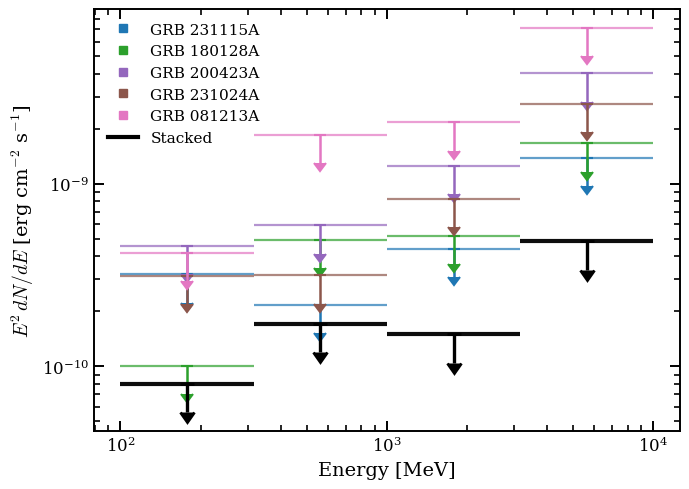

In [3]:
# === Overlay SEDs (individual + stacked) with UL caps at Eref (no manual arrows) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib as mpl

# ----- where results live -----
WORK_DIR = Path("/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis")

# ----- events & colors (match your flux-figure palette) -----
events_display = [
    "GRB 231115A",
    "GRB 200415A",
    "GRB 180128A",
    "GRB 120616A",
    "GRB 200423A",
    "GRB 231024A",
    "GRB 081213A",
]
colors = {grb: f"C{i%10}" for i, grb in enumerate(events_display)}

def candidate_folders(evt_name):
    return [evt_name, evt_name.replace(" ", "_"), evt_name.replace("_", " ")]

def find_event_folder(base: Path, evt_name: str):
    for cand in candidate_folders(evt_name):
        p = base / cand
        if p.exists():
            return p
    key = evt_name.replace(" ", "").replace("_", "").lower()
    for p in base.iterdir():
        if p.is_dir() and p.name.replace(" ", "").replace("_", "").lower() == key:
            return p
    return None

# ----- print-friendly style, same family as your flux plot -----
mpl.rcParams.update({
    "figure.figsize": (7,5),
    "savefig.dpi": 300,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "xtick.major.size": 7,
    "ytick.major.size": 7,
    "xtick.major.width": 1.4,
    "ytick.major.width": 1.4,
    "xtick.minor.size": 4,
    "ytick.minor.size": 4,
    "xtick.minor.width": 1.2,
    "ytick.minor.width": 1.2,
    "axes.linewidth": 1.4,
    "axes.labelpad": 4,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
    "font.family": "serif",
    "mathtext.fontset": "cm",
})

fig, ax = plt.subplots(figsize=(7.0, 5.0))

# 1) INDIVIDUAL SEDs: thin horizontal UL bars + UL caps at Eref; detections as filled circles
handles_evt, labels_evt = [], []
for ev in events_display:
    ev_dir = find_event_folder(WORK_DIR, ev)
    if ev_dir is None or not (ev_dir / "SED_points.csv").exists():
        print(f"[warn] Missing SED for {ev}")
        continue

    col = colors[ev]
    # legend handle for color
    h, = ax.plot([], [], marker='s', linestyle='None', color=col)
    handles_evt.append(h); labels_evt.append(ev)

    df = pd.read_csv(ev_dir / "SED_points.csv")
    E1  = df["Emin"].to_numpy(float)
    E2  = df["Emax"].to_numpy(float)
    X   = df["Eref"].to_numpy(float)
    Yul = df["E2dnde_UL_erg"].to_numpy(float)
    Y   = df.get("E2dnde_erg", pd.Series(np.full_like(X, np.nan))).to_numpy(float)
    TS  = df.get("TS", pd.Series(np.full_like(X, np.nan))).to_numpy(float)

    # UL horizontal bars
    for e1, e2, y in zip(E1, E2, Yul):
        if np.isfinite(y) and y > 0:
            ax.hlines(y, e1, e2, lw=1.6, alpha=0.7, color=col)

    # UL caps at Eref (match your previous style)
    for x, y in zip(X, Yul):
        if np.isfinite(y) and y > 0:
            ax.errorbar([x], [y], yerr=[0.3*y], fmt='none', uplims=True,
                        elinewidth=1.8, capsize=4, capthick=1.5, color=col)

    # Detections: filled circles at Eref
    det = (np.isfinite(TS) & (TS >= 9.0) & np.isfinite(Y) & (Y > 0))
    if np.any(det):
        ax.plot(X[det], Y[det], 'o', ms=6, mfc=col, mec='black', color=col)

# 2) STACKED SED: bold bars + bold caps at Eref; detections open black circles
stack_file = WORK_DIR / "stacked_SED_profiles.npz"
if stack_file.exists():
    st = np.load(stack_file, allow_pickle=True)
    E1s, E2s, Xs = st["Emin"], st["Emax"], st["Eref"]
    Yul_s        = st["E2dnde_UL_erg"]
    Y_s          = st["E2dnde_erg"]
    TS_s         = st["TSmax"]

    # Bold UL bars
    for e1, e2, y in zip(E1s, E2s, Yul_s):
        if np.isfinite(y) and y > 0:
            ax.hlines(y, e1, e2, lw=3.0, alpha=0.95, color="k")

    # Bold UL caps at Eref
    for x, y in zip(Xs, Yul_s):
        if np.isfinite(y) and y > 0:
            ax.errorbar([x], [y], yerr=[0.3*y], fmt='none', uplims=True,
                        elinewidth=2.4, capsize=5, capthick=2.0, color="k")

    # Stacked detections
    dets = (np.isfinite(TS_s) & (TS_s >= 9.0) & np.isfinite(Y_s) & (Y_s > 0))
    if np.any(dets):
        ax.plot(Xs[dets], Y_s[dets], 'o', ms=7, mfc='white', mec='k', color='k')

# axes, labels, legend
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel("Energy [MeV]")
ax.set_ylabel(r"$E^2\,dN/dE$ [erg cm$^{-2}$ s$^{-1}$]")

leg_handles, leg_labels = handles_evt, labels_evt
if stack_file.exists():
    leg_handles = leg_handles + [plt.Line2D([], [], color='k', lw=3)]
    leg_labels  = leg_labels  + ["Stacked"]
ax.legend(leg_handles, leg_labels, loc='upper left', frameon=False)

fig.tight_layout()
fig.savefig("lat_sed_points.pdf")
plt.show()


[warn] Missing SED for GRB 120616A


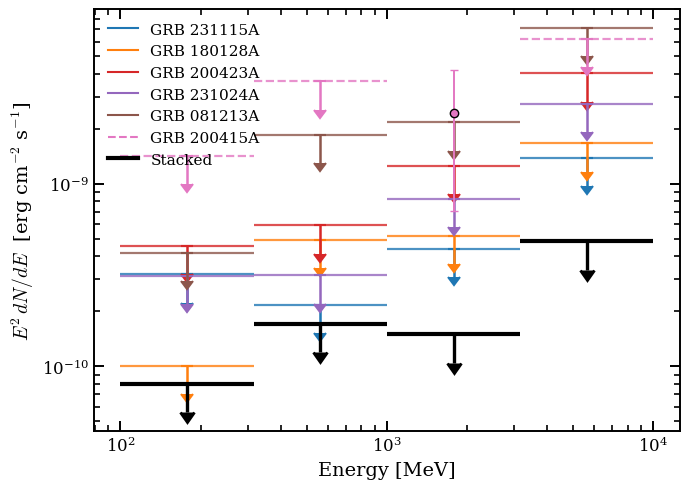

In [4]:
# === Overlay SEDs: individuals + GRB 200415A (special with 1σ error bar) + stacked ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib as mpl

WORK_DIR = Path("/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis")

# events normally inside folders:
events_display = [
    "GRB 231115A",
    "GRB 180128A",
    "GRB 120616A",
    "GRB 200423A",
    "GRB 231024A",
    "GRB 081213A",
]

# special single-file event (not stacked):
special_event = "GRB 200415A"
special_file  = WORK_DIR / "GRB_200415A_SED_points.csv"

# colors
colors = {ev: f"C{i%10}" for i, ev in enumerate(events_display + [special_event])}

# constants
MeV_to_erg = 1.602176634e-6

# --- helpers ---------------------------------------------------------------
def e2dnde_from_band_flux(Fband, E1, E2, Eref, gamma_pos):
    """PL2 with physical index gamma_pos>0: dN/dE ∝ E^{-gamma_pos}; return E^2 dN/dE at Eref (MeV cm^-2 s^-1)."""
    if not np.isfinite(Fband) or Fband <= 0:
        return np.nan
    if abs(gamma_pos - 1.0) > 1e-12:
        return Fband * (1.0 - gamma_pos) * (Eref**(2.0 - gamma_pos)) / (E2**(1.0 - gamma_pos) - E1**(1.0 - gamma_pos))
    return Fband * Eref / np.log(E2/E1)

def candidate_folders(evt_name):
    return [evt_name, evt_name.replace(" ", "_"), evt_name.replace("_", " ")]

def find_event_folder(base, evt_name):
    for cand in candidate_folders(evt_name):
        p = base / cand
        if p.is_dir() and (p / "SED_points.csv").exists():
            return p
    return None

# --- style -----------------------------------------------------------------
mpl.rcParams.update({
    "figure.figsize": (7,5),
    "savefig.dpi": 300,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "axes.linewidth": 1.4,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
    "font.family": "serif",
    "mathtext.fontset": "cm",
})

fig, ax = plt.subplots(figsize=(7,5))

def plot_single_event(df, col, linestyle="-", label=None, with_detection_errorbar=False):
    """Plot one event. If with_detection_errorbar=True, draw 1σ vertical error bars for detections (from FluxErr)."""
    # columns present in your CSVs:
    # Emin, Emax, Eref, TS_local, TS_global, det_flag, Index_used, Index_err,
    # Flux_MLE, FluxErr, UL95, E2dnde_erg, E2dnde_UL_erg

    E1  = df["Emin"].to_numpy(float)
    E2  = df["Emax"].to_numpy(float)
    X   = df["Eref"].to_numpy(float)

    # ULs
    Yul = df.get("E2dnde_UL_erg", pd.Series(np.full_like(X, np.nan))).to_numpy(float)
    for e1, e2, y in zip(E1, E2, Yul):
        if np.isfinite(y) and y > 0:
            ax.hlines(y, e1, e2, lw=1.6, color=col, alpha=0.8, linestyles=linestyle)
            ax.errorbar([np.sqrt(e1*e2)], [y], yerr=[0.3*y], fmt='none', uplims=True,
                        elinewidth=1.8, capsize=4, capthick=1.5, color=col)

    # Detections
    Y   = df.get("E2dnde_erg", pd.Series(np.full_like(X, np.nan))).to_numpy(float)
    TS  = df.get("TS", df.get("TS_local", pd.Series(np.full_like(X, np.nan)))).to_numpy(float)
    det = (np.isfinite(TS) & (TS >= 9.0) & np.isfinite(Y) & (Y > 0))

    if np.any(det) and with_detection_errorbar and ("Flux_MLE" in df.columns) and ("FluxErr" in df.columns):
        # Recompute vertical error bar from FluxErr for each detection bin
        Flux_MLE = df["Flux_MLE"].to_numpy(float)
        FluxErr  = df["FluxErr"].to_numpy(float)
        GammaPos = df.get("Index_used", pd.Series(np.full_like(X, np.nan))).to_numpy(float)

        yerr = np.full_like(Y, np.nan)
        for i in range(len(Y)):
            if det[i] and np.isfinite(FluxErr[i]) and (FluxErr[i] > 0):
                gpos = GammaPos[i] if np.isfinite(GammaPos[i]) and (GammaPos[i] > 0) else 2.0
                y_plus_mev = e2dnde_from_band_flux(Flux_MLE[i] + FluxErr[i], E1[i], E2[i], X[i], gpos)
                if np.isfinite(y_plus_mev):
                    yerr[i] = abs(y_plus_mev - (Y[i] / MeV_to_erg)) * MeV_to_erg  # convert Δ(MeV)→Δ(erg)
        ax.errorbar(X[det], Y[det], yerr=yerr[det], fmt='o', ms=6, mfc=col, mec='black',
                    elinewidth=1.4, capsize=3, color=col)
    else:
        if np.any(det):
            ax.plot(X[det], Y[det], 'o', ms=6, mfc=col, mec='black', color=col)

    # legend handle
    if label is not None:
        h, = ax.plot([], [], color=col, linestyle=linestyle)
        return h
    return None

# --- 1) normal individual events ------------------------------------------
handles_evt = []
labels_evt  = []

for ev in events_display:
    ev_dir = find_event_folder(WORK_DIR, ev)
    if ev_dir is None:
        print(f"[warn] Missing SED for {ev}")
        continue
    df = pd.read_csv(ev_dir / "SED_points.csv")
    h = plot_single_event(df, colors[ev], linestyle="-", label=ev, with_detection_errorbar=False)
    handles_evt.append(h); labels_evt.append(ev)

# --- 2) special GRB 200415A (distinct linestyle + show 1σ on detection) ----
if special_file.exists():
    df = pd.read_csv(special_file)
    h = plot_single_event(df, colors[special_event], linestyle="--", label=special_event,
                          with_detection_errorbar=True)
    handles_evt.append(h); labels_evt.append(special_event)
else:
    print("[warn] special GRB_200415A_SED_points.csv not found")

# --- 3) stacked SED --------------------------------------------------------
stack_file = WORK_DIR / "stacked_SED_profiles.npz"
if stack_file.exists():
    st = np.load(stack_file, allow_pickle=True)
    E1s, E2s, Xs = st["Emin"], st["Emax"], st["Eref"]
    Yul_s        = st["E2dnde_UL_erg"]
    Y_s          = st["E2dnde_erg"]
    TS_s         = st["TSmax"]

    for e1, e2, y in zip(E1s, E2s, Yul_s):
        if np.isfinite(y) and y > 0:
            ax.hlines(y, e1, e2, lw=3.0, alpha=1.0, color="k")
            ax.errorbar([np.sqrt(e1*e2)], [y], yerr=[0.3*y], fmt='none', uplims=True,
                        elinewidth=2.4, capsize=5, capthick=2.0, color="k")

    det = (TS_s >= 9.0) & np.isfinite(Y_s) & (Y_s > 0)
    if np.any(det):
        ax.plot(Xs[det], Y_s[det], 'o', ms=7, mfc='white', mec='k')

    stack_handle = plt.Line2D([], [], color="k", lw=3)
else:
    stack_handle = None

# --- axes & legend ---------------------------------------------------------
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel("Energy [MeV]")
ax.set_ylabel(r"$E^2\,dN/dE$  [erg cm$^{-2}$ s$^{-1}$]")

if stack_handle:
    handles = handles_evt + [stack_handle]
    labels  = labels_evt  + ["Stacked"]
else:
    handles = handles_evt
    labels  = labels_evt

ax.legend(handles, labels, loc="upper left", frameon=False)

fig.tight_layout()
fig.savefig("lat_sed_points.pdf")
plt.show()


[warn] Missing SED for GRB 120616A


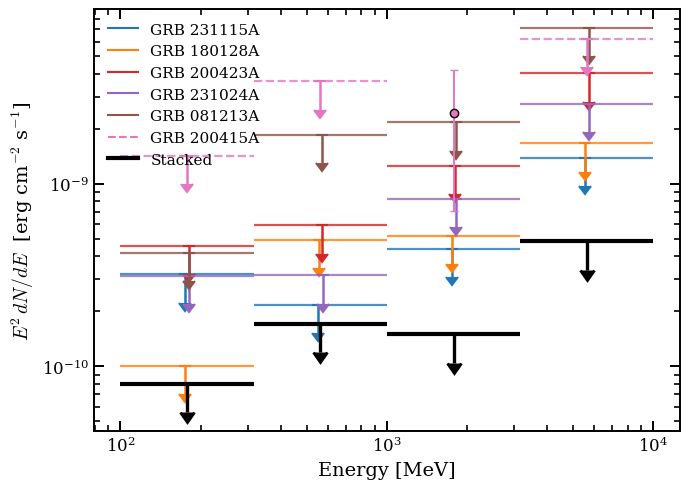

In [5]:
# === Overlay SEDs: individuals + GRB 200415A (special with 1σ error bar) + stacked ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib as mpl

WORK_DIR = Path("/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis")

# events normally inside folders:
events_display = [
    "GRB 231115A",
    "GRB 180128A",
    "GRB 120616A",
    "GRB 200423A",
    "GRB 231024A",
    "GRB 081213A",
]

# special single-file event (not stacked):
special_event = "GRB 200415A"
special_file  = WORK_DIR / "GRB_200415A_SED_points.csv"

# small log10 shifts to separate overlapping points slightly in x
# (units: dex; e.g. 0.03 ≈ 7% in energy)
event_log_shifts = {
    "GRB 231115A": -0.007,
    "GRB 180128A": -0.006,
    "GRB 120616A":  0.01,
    "GRB 200423A":  0.007,
    "GRB 231024A":  0.009,
    "GRB 081213A":  0.008,
    # keep GRB 200415A centered
    "GRB 200415A":  0.0,
}

# colors
colors = {ev: f"C{i%10}" for i, ev in enumerate(events_display + [special_event])}

# constants
MeV_to_erg = 1.602176634e-6

# --- helpers ---------------------------------------------------------------
def e2dnde_from_band_flux(Fband, E1, E2, Eref, gamma_pos):
    """PL2 with physical index gamma_pos>0: dN/dE ∝ E^{-gamma_pos}; return E^2 dN/dE at Eref (MeV cm^-2 s^-1)."""
    if not np.isfinite(Fband) or Fband <= 0:
        return np.nan
    if abs(gamma_pos - 1.0) > 1e-12:
        return Fband * (1.0 - gamma_pos) * (Eref**(2.0 - gamma_pos)) / (E2**(1.0 - gamma_pos) - E1**(1.0 - gamma_pos))
    return Fband * Eref / np.log(E2/E1)

def candidate_folders(evt_name):
    return [evt_name, evt_name.replace(" ", "_"), evt_name.replace("_", " ")]

def find_event_folder(base, evt_name):
    for cand in candidate_folders(evt_name):
        p = base / cand
        if p.is_dir() and (p / "SED_points.csv").exists():
            return p
    return None

# --- style -----------------------------------------------------------------
mpl.rcParams.update({
    "figure.figsize": (7,5),
    "savefig.dpi": 300,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "axes.linewidth": 1.4,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
    "font.family": "serif",
    "mathtext.fontset": "cm",
})

fig, ax = plt.subplots(figsize=(7,5))

def plot_single_event(df, col, linestyle="-", label=None,
                      with_detection_errorbar=False,
                      log_x_shift=0.0):
    """
    Plot one event.
    log_x_shift: small shift in log10(E) to avoid vertical overlap of points/UL arrows.
    If with_detection_errorbar=True, draw 1σ vertical error bars for detections (from FluxErr).
    """
    # columns present in your CSVs:
    # Emin, Emax, Eref, TS_local, TS_global, det_flag, Index_used, Index_err,
    # Flux_MLE, FluxErr, UL95, E2dnde_erg, E2dnde_UL_erg

    E1  = df["Emin"].to_numpy(float)
    E2  = df["Emax"].to_numpy(float)
    X   = df["Eref"].to_numpy(float)

    # apply shift factor in x (log10 shift -> multiplicative in E)
    shift_factor = 10.0**log_x_shift

    # ULs
    Yul = df.get("E2dnde_UL_erg", pd.Series(np.full_like(X, np.nan))).to_numpy(float)
    for e1, e2, y in zip(E1, E2, Yul):
        if np.isfinite(y) and y > 0:
            # keep hline at physical band edges (no shift)
            ax.hlines(y, e1, e2, lw=1.6, color=col, alpha=0.8, linestyles=linestyle)
            # shift the central arrow marker a bit in x
            x_mid = np.sqrt(e1 * e2) * shift_factor
            ax.errorbar([x_mid], [y], yerr=[0.3*y], fmt='none', uplims=True,
                        elinewidth=1.8, capsize=4, capthick=1.5, color=col)

    # Detections
    Y   = df.get("E2dnde_erg", pd.Series(np.full_like(X, np.nan))).to_numpy(float)
    TS  = df.get("TS", df.get("TS_local", pd.Series(np.full_like(X, np.nan)))).to_numpy(float)
    det = (np.isfinite(TS) & (TS >= 9.0) & np.isfinite(Y) & (Y > 0))

    X_det_shifted = X * shift_factor

    if np.any(det) and with_detection_errorbar and ("Flux_MLE" in df.columns) and ("FluxErr" in df.columns):
        # Recompute vertical error bar from FluxErr for each detection bin
        Flux_MLE = df["Flux_MLE"].to_numpy(float)
        FluxErr  = df["FluxErr"].to_numpy(float)
        GammaPos = df.get("Index_used", pd.Series(np.full_like(X, np.nan))).to_numpy(float)

        yerr = np.full_like(Y, np.nan)
        for i in range(len(Y)):
            if det[i] and np.isfinite(FluxErr[i]) and (FluxErr[i] > 0):
                gpos = GammaPos[i] if np.isfinite(GammaPos[i]) and (GammaPos[i] > 0) else 2.0
                y_plus_mev = e2dnde_from_band_flux(Flux_MLE[i] + FluxErr[i], E1[i], E2[i], X[i], gpos)
                if np.isfinite(y_plus_mev):
                    yerr[i] = abs(y_plus_mev - (Y[i] / MeV_to_erg)) * MeV_to_erg  # convert Δ(MeV)→Δ(erg)

        ax.errorbar(X_det_shifted[det], Y[det], yerr=yerr[det], fmt='o',
                    ms=6, mfc=col, mec='black',
                    elinewidth=1.4, capsize=3, color=col)
    else:
        if np.any(det):
            ax.plot(X_det_shifted[det], Y[det], 'o', ms=6, mfc=col, mec='black', color=col)

    # legend handle
    if label is not None:
        h, = ax.plot([], [], color=col, linestyle=linestyle)
        return h
    return None

# --- 1) normal individual events ------------------------------------------
handles_evt = []
labels_evt  = []

for ev in events_display:
    ev_dir = find_event_folder(WORK_DIR, ev)
    if ev_dir is None:
        print(f"[warn] Missing SED for {ev}")
        continue
    df = pd.read_csv(ev_dir / "SED_points.csv")
    log_shift = event_log_shifts.get(ev, 0.0)
    h = plot_single_event(df, colors[ev], linestyle="-", label=ev,
                          with_detection_errorbar=False,
                          log_x_shift=log_shift)
    handles_evt.append(h); labels_evt.append(ev)

# --- 2) special GRB 200415A (distinct linestyle + show 1σ on detection) ----
if special_file.exists():
    df = pd.read_csv(special_file)
    log_shift = event_log_shifts.get(special_event, 0.0)
    h = plot_single_event(df, colors[special_event], linestyle="--", label=special_event,
                          with_detection_errorbar=True,
                          log_x_shift=log_shift)
    handles_evt.append(h); labels_evt.append(special_event)
else:
    print("[warn] special GRB_200415A_SED_points.csv not found")

# --- 3) stacked SED --------------------------------------------------------
stack_file = WORK_DIR / "stacked_SED_profiles.npz"
if stack_file.exists():
    st = np.load(stack_file, allow_pickle=True)
    E1s, E2s, Xs = st["Emin"], st["Emax"], st["Eref"]
    Yul_s        = st["E2dnde_UL_erg"]
    Y_s          = st["E2dnde_erg"]
    TS_s         = st["TSmax"]

    for e1, e2, y in zip(E1s, E2s, Yul_s):
        if np.isfinite(y) and y > 0:
            ax.hlines(y, e1, e2, lw=3.0, alpha=1.0, color="k")
            x_mid = np.sqrt(e1 * e2)  # keep stacked at true center
            ax.errorbar([x_mid], [y], yerr=[0.3*y], fmt='none', uplims=True,
                        elinewidth=2.4, capsize=5, capthick=2.0, color="k")

    det = (TS_s >= 9.0) & np.isfinite(Y_s) & (Y_s > 0)
    if np.any(det):
        ax.plot(Xs[det], Y_s[det], 'o', ms=7, mfc='white', mec='k')

    stack_handle = plt.Line2D([], [], color="k", lw=3)
else:
    stack_handle = None

# --- axes & legend ---------------------------------------------------------
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel("Energy [MeV]")
ax.set_ylabel(r"$E^2\,dN/dE$  [erg cm$^{-2}$ s$^{-1}$]")

if stack_handle:
    handles = handles_evt + [stack_handle]
    labels  = labels_evt  + ["Stacked"]
else:
    handles = handles_evt
    labels  = labels_evt

ax.legend(handles, labels, loc="upper left", frameon=False)

fig.tight_layout()
fig.savefig("lat_sed_points.pdf")
plt.show()


[warn] Missing SED for GRB 120616A


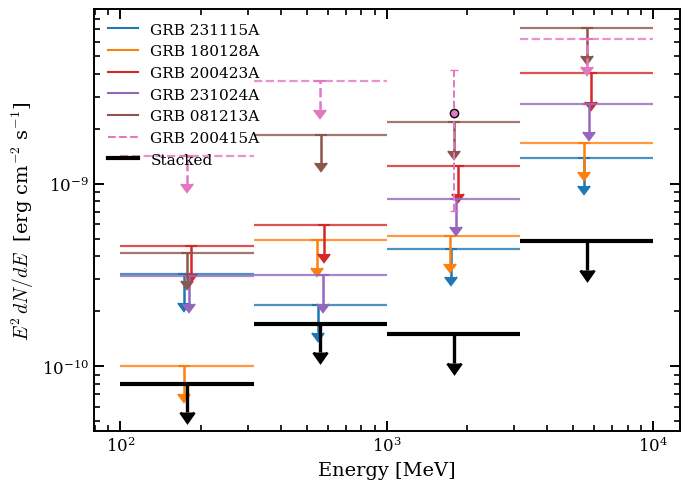

In [6]:
# === Overlay SEDs: individuals + GRB 200415A (special with 1σ error bar) + stacked ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib as mpl

WORK_DIR = Path("/Users/salim/Desktop/MGFs_LAT/MGF_LAT_analysis_trigger/MGF_Stacking_Analysis")

# events normally inside folders:
events_display = [
    "GRB 231115A",
    "GRB 180128A",
    "GRB 120616A",
    "GRB 200423A",
    "GRB 231024A",
    "GRB 081213A",
]

# special single-file event (not stacked):
special_event = "GRB 200415A"
special_file  = WORK_DIR / "GRB_200415A_SED_points.csv"

# small log10 shifts to separate overlapping points slightly in x
# (units: dex; e.g. 0.01 ≈ 2.3% in energy)
event_log_shifts = {
    "GRB 231115A": -0.01,
    "GRB 180128A": -0.012,
    "GRB 120616A":  0.01,
    "GRB 200423A":  0.015,
    "GRB 231024A":  0.009,
    "GRB 081213A":  0.001,
    # keep GRB 200415A centered
    "GRB 200415A":  0.0,
}

# colors
colors = {ev: f"C{i % 10}" for i, ev in enumerate(events_display + [special_event])}

# constants
MeV_to_erg = 1.602176634e-6

# --- helpers ---------------------------------------------------------------
def e2dnde_from_band_flux(Fband, E1, E2, Eref, gamma_pos):
    """
    PL2 with physical index gamma_pos>0: dN/dE ∝ E^{-gamma_pos};
    return E^2 dN/dE at Eref (MeV cm^-2 s^-1).
    """
    if not np.isfinite(Fband) or Fband <= 0:
        return np.nan
    if abs(gamma_pos - 1.0) > 1e-12:
        return (
            Fband * (1.0 - gamma_pos) * (Eref ** (2.0 - gamma_pos))
            / (E2 ** (1.0 - gamma_pos) - E1 ** (1.0 - gamma_pos))
        )
    return Fband * Eref / np.log(E2 / E1)

def candidate_folders(evt_name):
    return [evt_name, evt_name.replace(" ", "_"), evt_name.replace("_", " ")]

def find_event_folder(base, evt_name):
    for cand in candidate_folders(evt_name):
        p = base / cand
        if p.is_dir() and (p / "SED_points.csv").exists():
            return p
    return None

# --- style -----------------------------------------------------------------
mpl.rcParams.update({
    "figure.figsize": (7, 5),
    "savefig.dpi": 300,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "axes.linewidth": 1.4,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
    "font.family": "serif",
    "mathtext.fontset": "cm",
})

fig, ax = plt.subplots(figsize=(7, 5))

def plot_single_event(
    df,
    col,
    linestyle="-",
    label=None,
    with_detection_errorbar=False,
    log_x_shift=0.0,
):
    """
    Plot one event.

    log_x_shift: small shift in log10(E) to avoid vertical overlap of points/UL arrows.
    If with_detection_errorbar=True, draw 1σ vertical error bars for detections (from FluxErr).

    For GRB 200415A we call this with linestyle="--", so both
    the UL arrows AND detection error bars are dashed.
    """
    # CSV columns:
    # Emin, Emax, Eref, TS_local, TS_global, det_flag, Index_used, Index_err,
    # Flux_MLE, FluxErr, UL95, E2dnde_erg, E2dnde_UL_erg

    E1 = df["Emin"].to_numpy(float)
    E2 = df["Emax"].to_numpy(float)
    X  = df["Eref"].to_numpy(float)

    # apply shift factor in x (log10 shift -> multiplicative in E)
    shift_factor = 10.0 ** log_x_shift

    # ----------------- Upper limits -----------------
    Yul = df.get("E2dnde_UL_erg", pd.Series(np.full_like(X, np.nan))).to_numpy(float)
    for e1, e2, y in zip(E1, E2, Yul):
        if np.isfinite(y) and y > 0:
            # hline at physical band edges (no shift on band)
            ax.hlines(
                y, e1, e2,
                lw=1.6,
                color=col,
                alpha=0.8,
                linestyles=linestyle,
            )
            # shift the central arrow marker a bit in x
            x_mid = np.sqrt(e1 * e2) * shift_factor
            eb = ax.errorbar(
                [x_mid], [y], yerr=[0.3 * y],
                fmt="none",
                uplims=True,
                elinewidth=1.8,
                capsize=4,
                capthick=1.5,
                color=col,
            )
            # make the vertical UL bar dashed/solid according to linestyle
            for barcol in eb[2]:
                barcol.set_linestyle(linestyle)

    # ----------------- Detections -------------------
    Y  = df.get("E2dnde_erg", pd.Series(np.full_like(X, np.nan))).to_numpy(float)
    TS = df.get("TS", df.get("TS_local", pd.Series(np.full_like(X, np.nan)))).to_numpy(float)
    det = (np.isfinite(TS) & (TS >= 9.0) & np.isfinite(Y) & (Y > 0))

    X_det_shifted = X * shift_factor

    if np.any(det) and with_detection_errorbar and ("Flux_MLE" in df.columns) and ("FluxErr" in df.columns):
        # Recompute vertical error bar from FluxErr for each detection bin
        Flux_MLE = df["Flux_MLE"].to_numpy(float)
        FluxErr  = df["FluxErr"].to_numpy(float)
        GammaPos = df.get("Index_used", pd.Series(np.full_like(X, np.nan))).to_numpy(float)

        yerr = np.full_like(Y, np.nan)
        for i in range(len(Y)):
            if det[i] and np.isfinite(FluxErr[i]) and (FluxErr[i] > 0):
                gpos = GammaPos[i] if np.isfinite(GammaPos[i]) and (GammaPos[i] > 0) else 2.0
                y_plus_mev = e2dnde_from_band_flux(
                    Flux_MLE[i] + FluxErr[i],
                    E1[i], E2[i], X[i], gpos
                )
                if np.isfinite(y_plus_mev):
                    # convert Δ(MeV) -> Δ(erg)
                    yerr[i] = abs(y_plus_mev - (Y[i] / MeV_to_erg)) * MeV_to_erg

        # markers + error bars, but no connecting line (ls="none")
        eb = ax.errorbar(
            X_det_shifted[det],
            Y[det],
            yerr=yerr[det],
            fmt="o",
            ls="none",              # no line connecting points
            ms=6,
            mfc=col,
            mec="black",
            elinewidth=1.4,
            capsize=3,
            ecolor=col,
        )

        # make the vertical error bars dashed/solid according to linestyle
        for barcol in eb[2]:
            barcol.set_linestyle(linestyle)

    else:
        if np.any(det):
            ax.plot(
                X_det_shifted[det],
                Y[det],
                "o",
                ms=6,
                mfc=col,
                mec="black",
                color=col,
            )

    # legend handle
    if label is not None:
        h, = ax.plot([], [], color=col, linestyle=linestyle)
        return h
    return None

# --- 1) normal individual events ------------------------------------------
handles_evt = []
labels_evt  = []

for ev in events_display:
    ev_dir = find_event_folder(WORK_DIR, ev)
    if ev_dir is None:
        print(f"[warn] Missing SED for {ev}")
        continue

    df = pd.read_csv(ev_dir / "SED_points.csv")
    log_shift = event_log_shifts.get(ev, 0.0)

    h = plot_single_event(
        df,
        colors[ev],
        linestyle="-",
        label=ev,
        with_detection_errorbar=False,
        log_x_shift=log_shift,
    )
    handles_evt.append(h)
    labels_evt.append(ev)

# --- 2) special GRB 200415A (dashed UL + dashed error bars) ---------------
if special_file.exists():
    df = pd.read_csv(special_file)
    log_shift = event_log_shifts.get(special_event, 0.0)

    h = plot_single_event(
        df,
        colors[special_event],
        linestyle="--",              # dashed for this event
        label=special_event,
        with_detection_errorbar=True,
        log_x_shift=log_shift,
    )
    handles_evt.append(h)
    labels_evt.append(special_event)
else:
    print("[warn] special GRB_200415A_SED_points.csv not found")

# --- 3) stacked SED --------------------------------------------------------
stack_file = WORK_DIR / "stacked_SED_profiles.npz"
if stack_file.exists():
    st = np.load(stack_file, allow_pickle=True)
    E1s, E2s, Xs = st["Emin"], st["Emax"], st["Eref"]
    Yul_s        = st["E2dnde_UL_erg"]
    Y_s          = st["E2dnde_erg"]
    TS_s         = st["TSmax"]

    for e1, e2, y in zip(E1s, E2s, Yul_s):
        if np.isfinite(y) and y > 0:
            ax.hlines(
                y, e1, e2,
                lw=3.0,
                alpha=1.0,
                color="k",
            )
            x_mid = np.sqrt(e1 * e2)  # keep stacked at true center
            ax.errorbar(
                [x_mid], [y], yerr=[0.3 * y],
                fmt="none",
                uplims=True,
                elinewidth=2.4,
                capsize=5,
                capthick=2.0,
                color="k",
            )

    det = (TS_s >= 9.0) & np.isfinite(Y_s) & (Y_s > 0)
    if np.any(det):
        ax.plot(
            Xs[det],
            Y_s[det],
            "o",
            ms=7,
            mfc="white",
            mec="k",
        )

    stack_handle = plt.Line2D([], [], color="k", lw=3)
else:
    stack_handle = None

# --- axes & legend ---------------------------------------------------------
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Energy [MeV]")
ax.set_ylabel(r"$E^2\,dN/dE$  [erg cm$^{-2}$ s$^{-1}$]")

if stack_handle:
    handles = handles_evt + [stack_handle]
    labels  = labels_evt  + ["Stacked"]
else:
    handles = handles_evt
    labels  = labels_evt

ax.legend(handles, labels, loc="upper left", frameon=False)

fig.tight_layout()
fig.savefig("lat_sed_points.pdf")
plt.show()
